In [19]:
pip install dtaidistance

In [20]:
import math, time, re, os, glob
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from dtaidistance import dtw
import matplotlib.pyplot as plt

In [21]:
BASE_DIR=Path("/content/drive/MyDrive/Dance_clean_data")

In [22]:
SEQ_IN,SEQ_OUT=30,30
BATCH=128
EPOCHS=10
LR=3e-4
WDECAY=1e-4
D_MODEL=128
NHEAD=8
N_ENC=2
N_DEC=2
DROPOUT=0.1
VEL_W=0.1
GRAD_CLIP=1.0
WINDOW_STRIDE_EVAL=10
MAX_EVAL_WINDOWS=20000
MAX_DTW_SAMPLES=64
ROOT_IDXS=[]

In [23]:
DEVICE=torch.device("cuda" if torch.cuda.is_available() else "cpu")
AMP=torch.cuda.is_available()
torch.backends.cudnn.benchmark=True
try: torch.set_float32_matmul_precision('high')
except: pass

In [24]:
def dancer_from_path(p: Path):
    m=re.match(r"^(D\d+)",p.parent.name)
    return m.group(1) if m else p.parent.name

def load_npy_by_pattern(base_dir: Path,ps: str,edim=None):
    b={}
    for f in base_dir.rglob("*.npy"):
        if ps.lower() not in f.name.lower():
            continue
        arr=np.load(f)
        if arr.ndim!=2:
            continue
        if edim is not None and arr.shape[1]!=edim:
            continue
        d=dancer_from_path(f)
        b.setdefault(d, []).append(arr.astype(np.float32))
    return b

def vstack_or_empty(la,D=None):
    if not la:
        return np.empty((0, D if D is not None else 0),np.float32)
    return np.vstack(la).astype(np.float32)


In [25]:
def build_io(data_2d,in_len=30,out_len=30,feat_dim=None,stride=1):
    T=len(data_2d)
    if feat_dim is None: feat_dim=data_2d.shape[1] if data_2d.ndim==2 else 0
    if T<in_len+out_len:
        return (np.empty((0,in_len,feat_dim),np.float32),
                np.empty((0,out_len,feat_dim),np.float32))
    X,Y=[],[]
    for i in range(0,T-in_len-out_len+1,stride):
        X.append(data_2d[i:i+in_len])
        Y.append(data_2d[i+in_len:i+in_len+out_len])
    return np.stack(X).astype(np.float32),np.stack(Y).astype(np.float32)

In [26]:
def fit_scaler(X_windows):
    sc=StandardScaler().fit(X_windows.reshape(-1, X_windows.shape[-1]))
    mu,sig=sc.mean_.astype(np.float32),sc.scale_.astype(np.float32)
    sig[sig==0]=1.0
    return mu, sig

def transform_safe(x,mu,sig): return (x - mu)/sig
def inv_transform_safe(x, mu, sig): return x*sig+mu

In [27]:
def gen_mask(sz, device):
    m=torch.full((sz,sz),float('-inf'),device=device)
    m=torch.triu(m,diagonal=1)
    m=m.masked_fill(m==0,0.0)
    return m

In [28]:
class PositionalEncoding(nn.Module):
    def __init__(self,d_model,max_len=2048):
        super().__init__()
        pe=torch.zeros(max_len,d_model)
        pos=torch.arange(0,max_len,dtype=torch.float32).unsqueeze(1)
        div=torch.exp(torch.arange(0, d_model, 2).float()*(-math.log(10000.0)/d_model))
        pe[:,0::2]=torch.sin(pos*div)
        pe[:,1::2]=torch.cos(pos*div)
        self.register_buffer("pe", pe.unsqueeze(0))
    def forward(self,x):
        return x+self.pe[:,:x.size(1)]

In [29]:
class MotionTransformer(nn.Module):
    def __init__(self, input_dim,d_model=D_MODEL,nhead=NHEAD,num_enc=N_ENC,num_dec=N_DEC,dropout=DROPOUT,seq_out=SEQ_OUT):
        super().__init__()
        self.seq_out=seq_out
        self.in_proj=nn.Linear(input_dim,d_model)
        self.out_proj=nn.Linear(d_model,input_dim)
        self.pos_enc=PositionalEncoding(d_model)

        enc_layer=nn.TransformerEncoderLayer(d_model,nhead,dim_feedforward=4*d_model,dropout=dropout,batch_first=True)
        dec_layer=nn.TransformerDecoderLayer(d_model,nhead,dim_feedforward=4*d_model,dropout=dropout,batch_first=True)
        self.encoder=nn.TransformerEncoder(enc_layer,num_layers=num_enc)
        self.decoder=nn.TransformerDecoder(dec_layer,num_layers=num_dec)

        self.cached_mask=None
        self.cached_len=0

    def _get_tgt_mask(self,L,device):
        if self.cached_mask is None or self.cached_len < L or self.cached_mask.device != device:
            self.cached_mask=gen_mask(L,device)
            self.cached_len=L
        return self.cached_mask[:L,:L]

    def velocity(self, x):
        return x[:,1:,:]-x[:,:-1,:]

    def forward_train(self,src,tgt):
        B,Lin,D=src.shape
        Lout=tgt.size(1)
        mem=self.encoder(self.pos_enc(self.in_proj(src)))
        start=src[:, -1:, :]
        dec_in=torch.cat([start, tgt[:, :-1, :]],dim=1)
        dec_e=self.pos_enc(self.in_proj(dec_in))
        mask=self._get_tgt_mask(Lout,dec_e.device)
        dec_h=self.decoder(dec_e,mem,tgt_mask=mask)
        return self.out_proj(dec_h)

    @torch.no_grad()
    def forward_eval(self,src):
        B,Lin,D=src.shape
        mem=self.encoder(self.pos_enc(self.in_proj(src)))
        dec_abs=src[:,-1:,:]
        outs=[]
        for _ in range(self.seq_out):
            dec_e=self.pos_enc(self.in_proj(dec_abs))
            mask=self._get_tgt_mask(dec_e.size(1), dec_e.device)
            dec_h=self.decoder(dec_e, mem,tgt_mask=mask)
            next_abs=self.out_proj(dec_h[:,-1:,:])
            outs.append(next_abs)
            dec_abs=torch.cat([dec_abs,next_abs],dim=1)
        return torch.cat(outs,dim=1)

In [30]:
def train_transformer(X_tr,Y_tr,X_val,Y_val,d_feat,tag=""):
    model=MotionTransformer(input_dim=d_feat).to(DEVICE)
    opt=torch.optim.AdamW(model.parameters(),lr=LR,weight_decay=WDECAY)
    loss_pos=nn.SmoothL1Loss()
    scaler=torch.amp.GradScaler("cuda",enabled=AMP)

    def velocity(x): return x[:,1:,:] - x[:,:-1,:]

    train_loader=DataLoader(TensorDataset(torch.tensor(X_tr),torch.tensor(Y_tr)),batch_size=BATCH, shuffle=True, drop_last=True,
                              num_workers=0,pin_memory=False)
    val_loader=DataLoader(TensorDataset(torch.tensor(X_val), torch.tensor(Y_val)),batch_size=BATCH, shuffle=False, drop_last=False,
                              num_workers=0,pin_memory=False)

    print("\nTraining:")
    for ep in range(1, EPOCHS+1):
        model.train(); tot=0.0; t0=time.time()
        for xb,yb in train_loader:
            xb=xb.to(DEVICE); yb=yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast("cuda",enabled=AMP):
                pred=model.forward_train(xb,yb)
                loss=loss_pos(pred,yb)+VEL_W*loss_pos(velocity(pred),velocity(yb))
            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(model.parameters(),GRAD_CLIP)
            scaler.step(opt); scaler.update()
            tot+=loss.item()

        model.eval(); vtot=0.0; t1=time.time()
        with torch.no_grad(), torch.amp.autocast("cuda", enabled=AMP):
            for xb,yb in val_loader:
                xb=xb.to(DEVICE); yb=yb.to(DEVICE)
                pred=model.forward_eval(xb)
                vtot+=(loss_pos(pred, yb)+VEL_W*loss_pos(velocity(pred),velocity(yb))).item()
        print(f"Epoch {ep:02d} | Train: {tot/len(train_loader):.5f}  Val: {vtot/len(val_loader):.5f}")

    return model

In [31]:
@torch.no_grad()
def evaluate(model,X,Y,name="",max_dtw=MAX_DTW_SAMPLES,mu=None,sig=None):
    if len(X)==0:
        #print(f"{name}: no windows.")
        return None
    Xt=torch.tensor(X,dtype=torch.float32,device=DEVICE)
    with torch.amp.autocast("cuda",enabled=AMP):
        pred=model.forward_eval(Xt).cpu().numpy()
    gt=Y
    l1=float(np.mean(np.abs(pred-gt)))
    l2=float(np.mean((pred-gt)**2))
    k=min(len(gt),max_dtw)
    dvals=[dtw.distance(pred[i].reshape(-1), gt[i].reshape(-1)) for i in range(k)]
    print(f"{name}: L1={l1:.4f}  L2={l2:.4f}  DTW(n={k})={np.mean(dvals):.4f}")
    return {"l1": l1, "l2": l2, "dtw": float(np.mean(dvals))}

In [32]:
def windows_eval(long_arr,mu,sig,d_feat,name):
    Xr,Yr=build_io(long_arr,SEQ_IN,SEQ_OUT,feat_dim=d_feat,stride=WINDOW_STRIDE_EVAL)
    if Xr.size==0:
        #print(f"[eval-build] {name}: 0 windows")
        return (np.empty((0,SEQ_IN,d_feat), np.float32), np.empty((0,SEQ_OUT,d_feat), np.float32))
    if len(Xr)>MAX_EVAL_WINDOWS:
        idx=np.linspace(0,len(Xr)-1,num=MAX_EVAL_WINDOWS,dtype=int)
        Xr,Yr=Xr[idx],Yr[idx]
    Xs=transform_safe(Xr,mu,sig)
    Ys=transform_safe(Yr,mu,sig)
    #print(f"[eval-build] {name}: {Xs.shape} windows (stride={WINDOW_STRIDE_EVAL}, cap={MAX_EVAL_WINDOWS})")
    return Xs,Ys

In [33]:
train_by_d=load_npy_by_pattern(BASE_DIR,"train")
zig_by_d=load_npy_by_pattern(BASE_DIR,"zigzag")
circ_by_d=load_npy_by_pattern(BASE_DIR,"circle")
all_ds=sorted(set(train_by_d)|set(zig_by_d)|set(circ_by_d))

D_group={f"D{i}" for i in range(1,6)}
N_group={f"D{i}" for i in range(6,11)}

def concat_group(b, ids):
    if not b: return np.empty((0,0), np.float32)
    any_d = next(iter(b))
    Ddim=b[any_d][0].shape[1]
    return vstack_or_empty([arr for d in ids for arr in b.get(d, [])], D=Ddim)

train_D=concat_group(train_by_d,D_group)
train_N=concat_group(train_by_d,N_group)
zig_D=concat_group(zig_by_d,D_group)
zig_N=concat_group(zig_by_d,N_group)
circ_D=concat_group(circ_by_d,D_group)
circ_N=concat_group(circ_by_d,N_group)

print("Shapes– train(D):", train_D.shape, " train(N):", train_N.shape," zig(D):", zig_D.shape, " zig(N):", zig_N.shape,
      " circle(D):", circ_D.shape, " circle(N):", circ_N.shape)

if train_D.size>0: D=train_D.shape[1]
elif train_N.size>0: D=train_N.shape[1]
else: raise RuntimeError("No train .npy found.")

Shapes– train(D): (167564, 112)  train(N): (163944, 112)  zig(D): (67560, 112)  zig(N): (64474, 112)  circle(D): (71661, 112)  circle(N): (66863, 112)


In [34]:
def train_windows(long_arr, name):
    Xr,Yr=build_io(long_arr,SEQ_IN,SEQ_OUT,feat_dim=D,stride=1)
    print(f"{name} windows:", Xr.shape, Yr.shape)
    n=len(Xr)
    if n == 0:
        return (np.empty((0,SEQ_IN,D),np.float32), np.empty((0,SEQ_OUT,D),np.float32),
                np.empty((0,SEQ_IN,D),np.float32), np.empty((0,SEQ_OUT,D),np.float32))
    n_val=max(int(0.1*n),1)
    return Xr[:-n_val],Yr[:-n_val],Xr[-n_val:],Yr[-n_val:]

Xtr_D,Ytr_D,Xval_D,Yval_D=train_windows(train_D, "Train(D)")
Xtr_N,Ytr_N,Xval_N,Yval_N=train_windows(train_N, "Train(N)")

Train(D) windows: (167505, 30, 112) (167505, 30, 112)
Train(N) windows: (163885, 30, 112) (163885, 30, 112)


In [35]:
def prep(Xtr,Ytr,Xval,Yval):
    if len(Xtr)==0: return None
    mu,sig=fit_scaler(Xtr)
    return (mu,sig,transform_safe(Xtr,mu, sig),transform_safe(Ytr,mu,sig),transform_safe(Xval,mu,sig),transform_safe(Yval,mu,sig))

norm_D=prep(Xtr_D,Ytr_D,Xval_D,Yval_D)
norm_N=prep(Xtr_N,Ytr_N,Xval_N,Yval_N)

In [36]:
model_D=model_N=None
if norm_D:
    mu_D,sig_D,Xtr_Dn,Ytr_Dn,Xval_Dn,Yval_Dn=norm_D
    model_D=train_transformer(Xtr_Dn,Ytr_Dn,Xval_Dn,Yval_Dn,d_feat=D,tag="Dtrained")
if norm_N:
    mu_N,sig_N,Xtr_Nn,Ytr_Nn,Xval_Nn,Yval_Nn=norm_N
    model_N=train_transformer(Xtr_Nn,Ytr_Nn,Xval_Nn,Yval_Nn,d_feat=D,tag="Ntrained")



Training:
Epoch 01 | Train: 0.01972  Val: 0.01632
Epoch 02 | Train: 0.00225  Val: 0.01251
Epoch 03 | Train: 0.00125  Val: 0.01277
Epoch 04 | Train: 0.00089  Val: 0.00980
Epoch 05 | Train: 0.00071  Val: 0.01076
Epoch 06 | Train: 0.00060  Val: 0.00949
Epoch 07 | Train: 0.00054  Val: 0.00993
Epoch 08 | Train: 0.00050  Val: 0.00832
Epoch 09 | Train: 0.00048  Val: 0.00856
Epoch 10 | Train: 0.00046  Val: 0.00770

Training:
Epoch 01 | Train: 0.02055  Val: 0.04932
Epoch 02 | Train: 0.00252  Val: 0.05267
Epoch 03 | Train: 0.00139  Val: 0.04952
Epoch 04 | Train: 0.00098  Val: 0.04331
Epoch 05 | Train: 0.00077  Val: 0.03896
Epoch 06 | Train: 0.00065  Val: 0.03709
Epoch 07 | Train: 0.00058  Val: 0.03374
Epoch 08 | Train: 0.00053  Val: 0.03401
Epoch 09 | Train: 0.00050  Val: 0.03558
Epoch 10 | Train: 0.00048  Val: 0.03161


In [37]:
def eval_regime(model,mu,sig,tag):
    Xd,Yd=windows_eval(train_D,mu,sig,D,f"{tag}->Train(D)")
    Xn,Yn=windows_eval(train_N,mu,sig,D,f"{tag}->Train(N)")
    Xzd,Yzd=windows_eval(zig_D,mu,sig,D,f"{tag}->Zig(D)")
    Xzn,Yzn=windows_eval(zig_N,mu,sig,D,f"{tag}->Zig(N)")
    Xcd,Ycd=windows_eval(circ_D,mu,sig,D,f"{tag}->Circle(D)")
    Xcn,Ycn=windows_eval(circ_N,mu,sig,D,f"{tag}->Circle(N)")

    print()
    evaluate(model,Xd,Yd,name=f"{tag} – Train(D)")
    evaluate(model,Xn,Yn,name=f"{tag} – Train(N)")
    evaluate(model,Xzd,Yzd,name=f"{tag} – Zigzag(D)")
    evaluate(model,Xzn,Yzn,name=f"{tag} – Zigzag(N)")
    evaluate(model,Xcd,Ycd,name=f"{tag} – Circle(D)")
    evaluate(model,Xcn,Ycn,name=f"{tag} – Circle(N)")


In [38]:
if model_D:
    print("\Model_D(trained on D1–D5)")
    eval_regime(model_D,mu_D,sig_D,"Dtrained")

if model_N:
    print("Model_N(trained on D6–D10)")
    eval_regime(model_N,mu_N,sig_N,"Ntrained")

<>:2: SyntaxWarning: invalid escape sequence '\M'
<>:2: SyntaxWarning: invalid escape sequence '\M'
/tmp/ipython-input-596490559.py:2: SyntaxWarning: invalid escape sequence '\M'
  print("\Model_D(trained on D1–D5)")


\Model_D(trained on D1–D5)

Dtrained – Train(D): L1=0.0665  L2=0.0236  DTW(n=64)=4.1931
Dtrained – Train(N): L1=0.1371  L2=0.0769  DTW(n=64)=6.3173
Dtrained – Zigzag(D): L1=0.1442  L2=0.0733  DTW(n=64)=8.0833
Dtrained – Zigzag(N): L1=0.1852  L2=0.1099  DTW(n=64)=6.5339
Dtrained – Circle(D): L1=0.1247  L2=0.0437  DTW(n=64)=5.9544
Dtrained – Circle(N): L1=0.1271  L2=0.0445  DTW(n=64)=7.4455
Model_N(trained on D6–D10)

Ntrained – Train(D): L1=0.0931  L2=0.0360  DTW(n=64)=4.9984
Ntrained – Train(N): L1=0.0719  L2=0.0291  DTW(n=64)=3.3947
Ntrained – Zigzag(D): L1=0.1753  L2=0.0936  DTW(n=64)=8.9218
Ntrained – Zigzag(N): L1=0.1811  L2=0.1017  DTW(n=64)=5.6300
Ntrained – Circle(D): L1=0.1398  L2=0.0524  DTW(n=64)=7.8469
Ntrained – Circle(N): L1=0.1307  L2=0.0474  DTW(n=64)=6.6921


In [39]:
@torch.no_grad()
def predict_full_file(arr,model,mu,sig,seq_in=SEQ_IN,seq_out=SEQ_OUT,step=1,device=DEVICE):
    model.eval()
    T,D=arr.shape
    if T<=seq_in: raise ValueError("File too short to predict: T <= seq_in")
    Xs=(arr-mu)/sig

    pred_sum=np.zeros((T,D),dtype=np.float32)
    pred_count=np.zeros((T,),dtype=np.int32)

    with torch.amp.autocast("cuda", enabled=(device.type=='cuda')):
        for s in range(0, T-seq_in,step):
            ctx=Xs[s:s+seq_in]
            xb=torch.tensor(ctx, dtype=torch.float32, device=device)[None, ...]
            pred=model.forward_eval(xb).cpu().numpy()[0]
            for k in range(seq_out):
                t=s+seq_in+k
                if t>=T: break
                pred_sum[t]+=pred[k]
                pred_count[t]+=1

    valid=pred_count > 0
    pred_full=np.zeros_like(arr,dtype=np.float32)
    den=np.maximum(pred_count[valid].astype(np.float32)[:,None], 1.0)
    pred_full[valid]=(pred_sum[valid]/ den)*sig+mu
    pred_full[:seq_in]=arr[:seq_in]
    return pred_full,valid

def _prep_xyz(gt,pred,xyz_idx=(0,1,2),normalize_to_last_context=True,ctx_len=30):
    xi,yi,zi=xyz_idx
    T=gt.shape[0]
    gt_xyz=gt[:, [xi, yi, zi]].astype(np.float32)
    pred_xyz=pred[:, [xi, yi, zi]].astype(np.float32)
    if normalize_to_last_context and T>ctx_len:
        origin=gt_xyz[ctx_len-1].copy()
        gt_xyz=gt_xyz-origin
        pred_xyz=pred_xyz-origin
        ctx_pt=np.zeros(3, np.float32); suffix=" (normalized to last context)"
    else:
        ctx_pt=gt_xyz[min(ctx_len-1,T-1)]; suffix=""
    return gt_xyz,pred_xyz,ctx_pt,suffix

def plot_3d(gt,pred,title="file",xyz_idx=(0,1,2), normalize_to_last_context=True,ctx_len=30,figsize=(12,9)):
    gt_xyz,pred_xyz,ctx_pt,suffix= _prep_xyz(gt,pred,xyz_idx,normalize_to_last_context, ctx_len)
    fig=plt.figure(figsize=figsize); ax3=fig.add_subplot(111, projection='3d')
    ax3.plot(gt_xyz[ctx_len:,0],gt_xyz[ctx_len:,1],gt_xyz[ctx_len:,2], '--', lw=2, label='GT')
    ax3.plot(pred_xyz[ctx_len:,0],pred_xyz[ctx_len:,1],pred_xyz[ctx_len:,2], '-',  lw=2, label='Pred')
    ax3.scatter(ctx_pt[0], ctx_pt[1], ctx_pt[2], s=60, c='k', label='context end')
    ax3.set_title(title + suffix); ax3.set_xlabel('X'); ax3.set_ylabel('Y'); ax3.set_zlabel('Z'); ax3.legend()
    try:
        mins=np.minimum(gt_xyz.min(0), pred_xyz.min(0)); maxs = np.maximum(gt_xyz.max(0), pred_xyz.max(0))
        ax3.set_box_aspect((maxs-mins))
    except Exception: pass
    plt.tight_layout(); plt.show()

def plot_2d(gt,pred,title="file",xyz_idx=(0,1,2),normalize_to_last_context=True, ctx_len=30, figsize=(16,5)):
    gt_xyz,pred_xyz,ctx_pt,suffix=_prep_xyz(gt,pred,xyz_idx,normalize_to_last_context, ctx_len)
    fig,axes=plt.subplots(1,3, figsize=figsize)
    (ax_xy,ax_xz,ax_yz)=axes
    ax_xy.plot(gt_xyz[ctx_len:,0], gt_xyz[ctx_len:,1], '--', lw=2, label='GT')
    ax_xy.plot(pred_xyz[ctx_len:,0], pred_xyz[ctx_len:,1], '-',  lw=2, label='Pred')
    ax_xy.scatter(ctx_pt[0], ctx_pt[1], c='k', marker='x', s=50, label='ctx'); ax_xy.set_title(f"{title} – X–Y{suffix}"); ax_xy.legend()

    ax_xz.plot(gt_xyz[ctx_len:,0], gt_xyz[ctx_len:,2], '--', lw=2, label='GT')
    ax_xz.plot(pred_xyz[ctx_len:,0], pred_xyz[ctx_len:,2], '-',  lw=2, label='Pred')
    ax_xz.scatter(ctx_pt[0], ctx_pt[2], c='k', marker='x', s=50); ax_xz.set_title("X–Z"); ax_xz.legend()

    ax_yz.plot(gt_xyz[ctx_len:,1], gt_xyz[ctx_len:,2], '--', lw=2, label='GT')
    ax_yz.plot(pred_xyz[ctx_len:,1], pred_xyz[ctx_len:,2], '-',  lw=2, label='Pred')
    ax_yz.scatter(ctx_pt[1], ctx_pt[2], c='k', marker='x', s=50); ax_yz.set_title("Y–Z"); ax_yz.legend()
    for ax in axes: ax.grid(True, alpha=0.2)
    plt.tight_layout(); plt.show()


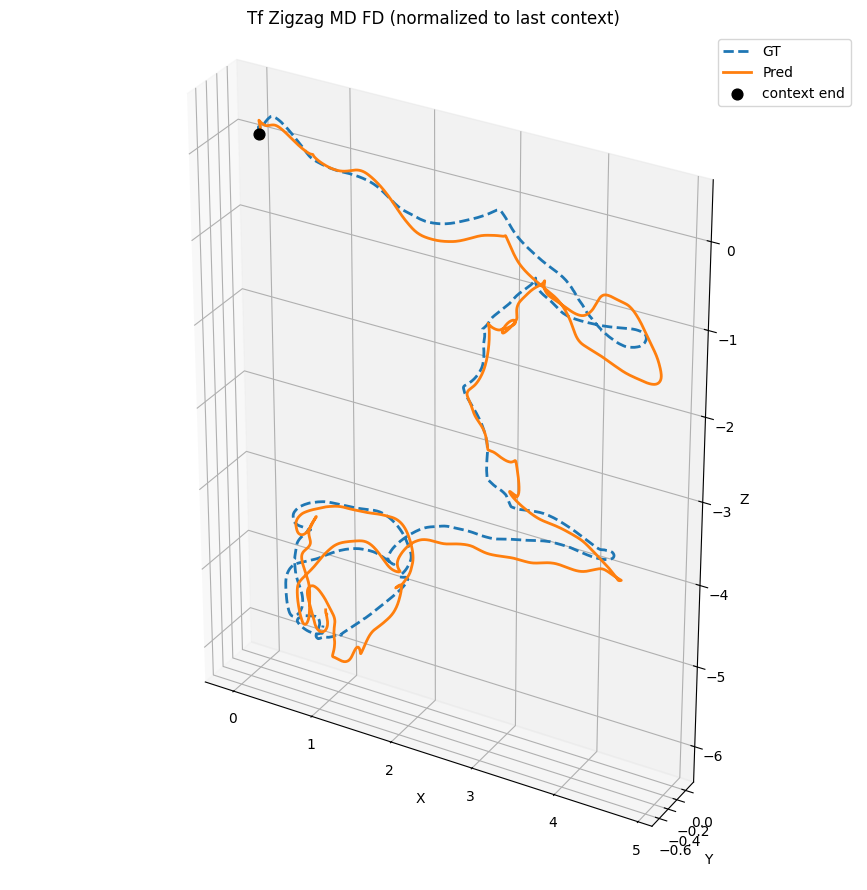

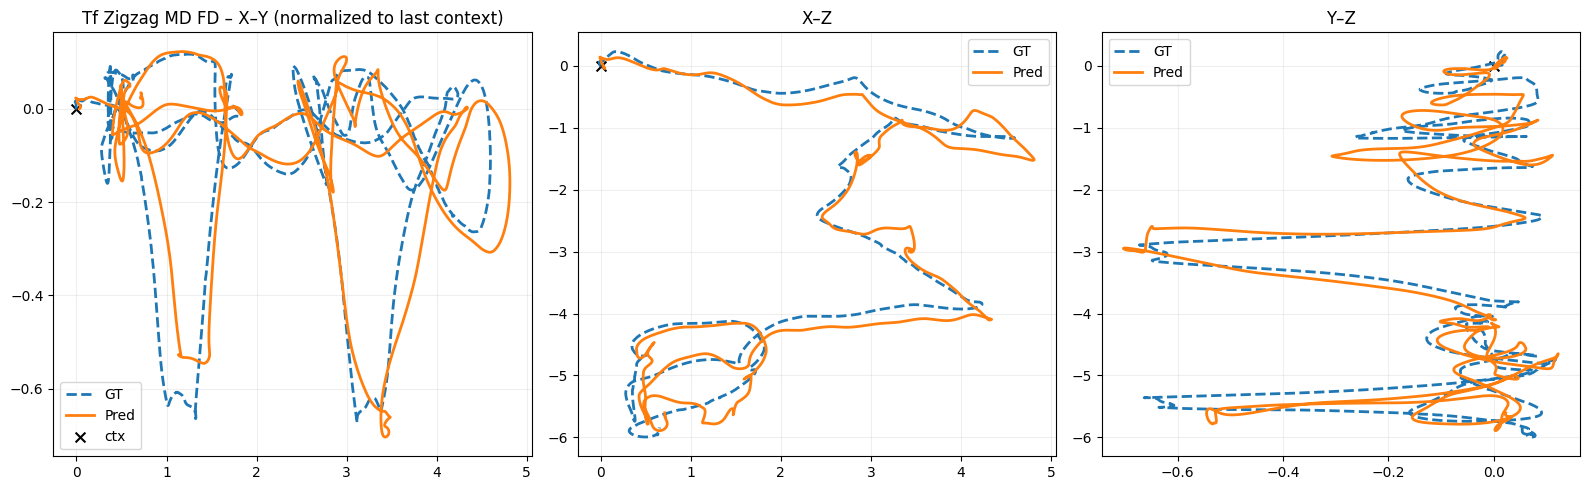

In [50]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D1_All_CSVs/cleaned_Take 072817_Sub1_NewZigZag1 12.26.30 PM edit.npy"
arr = np.load(file_path).astype(np.float32)
model, mu, sig = model_D, mu_D, sig_D
# model, mu, sig = model_N, mu_N, sig_N
pred_full, valid_mask = predict_full_file(arr, model, mu, sig,seq_in=SEQ_IN, seq_out=SEQ_OUT, step=1, device=DEVICE)

plot_3d(gt=arr, pred=pred_full,title="Tf Zigzag MD FD",xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(12,9))

plot_2d(gt=arr, pred=pred_full, title="Tf Zigzag MD FD", xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(16,5))

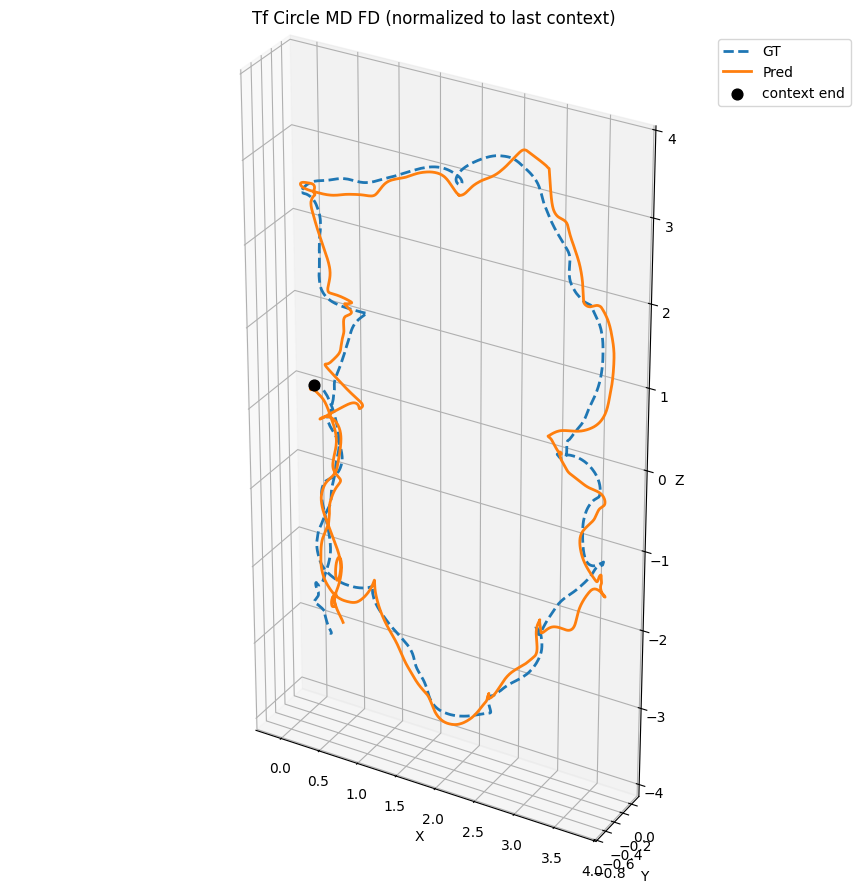

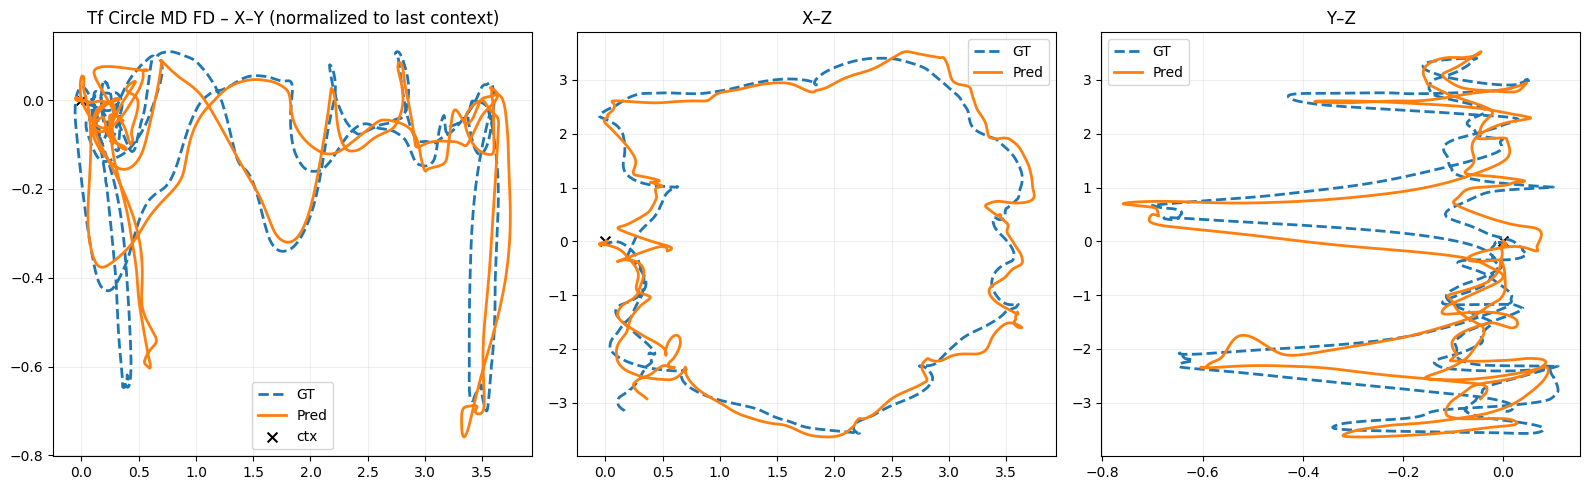

In [51]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D2_All_CSVs/cleaned_Take 080317_Sub2_Circle3 10.41.27 AM edit.npy"
arr = np.load(file_path).astype(np.float32)
model, mu, sig = model_D, mu_D, sig_D
# model, mu, sig = model_N, mu_N, sig_N
pred_full, valid_mask = predict_full_file(arr, model, mu, sig,seq_in=SEQ_IN, seq_out=SEQ_OUT, step=1, device=DEVICE)

plot_3d(gt=arr, pred=pred_full,title="Tf Circle MD FD",xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(12,9))

plot_2d(gt=arr, pred=pred_full, title="Tf Circle MD FD", xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(16,5))

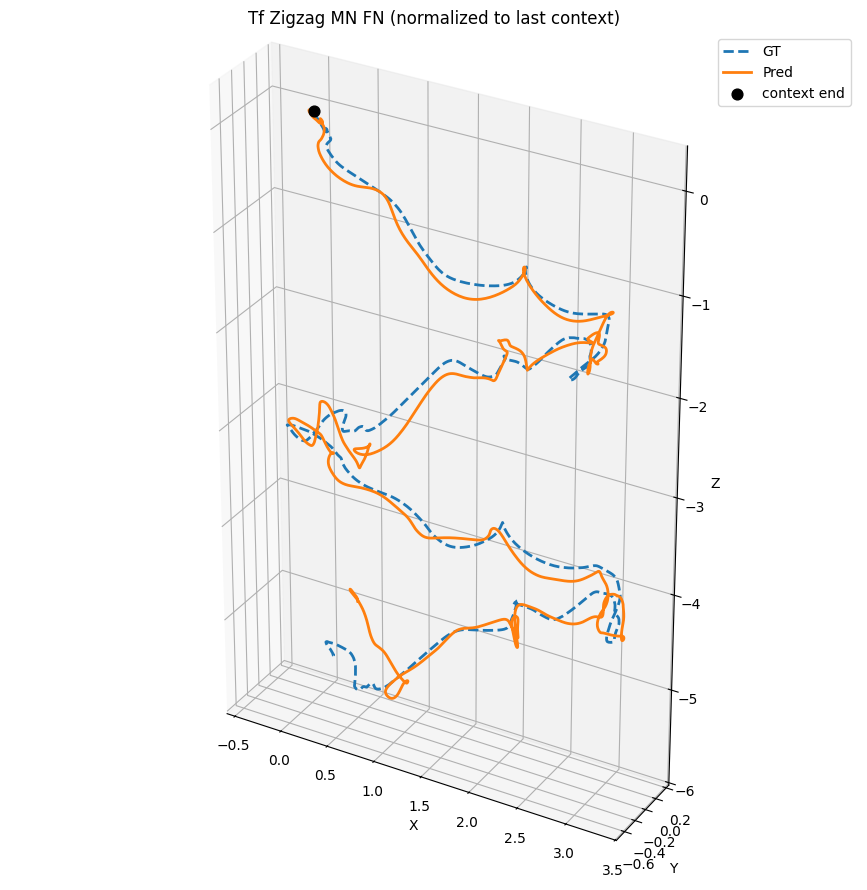

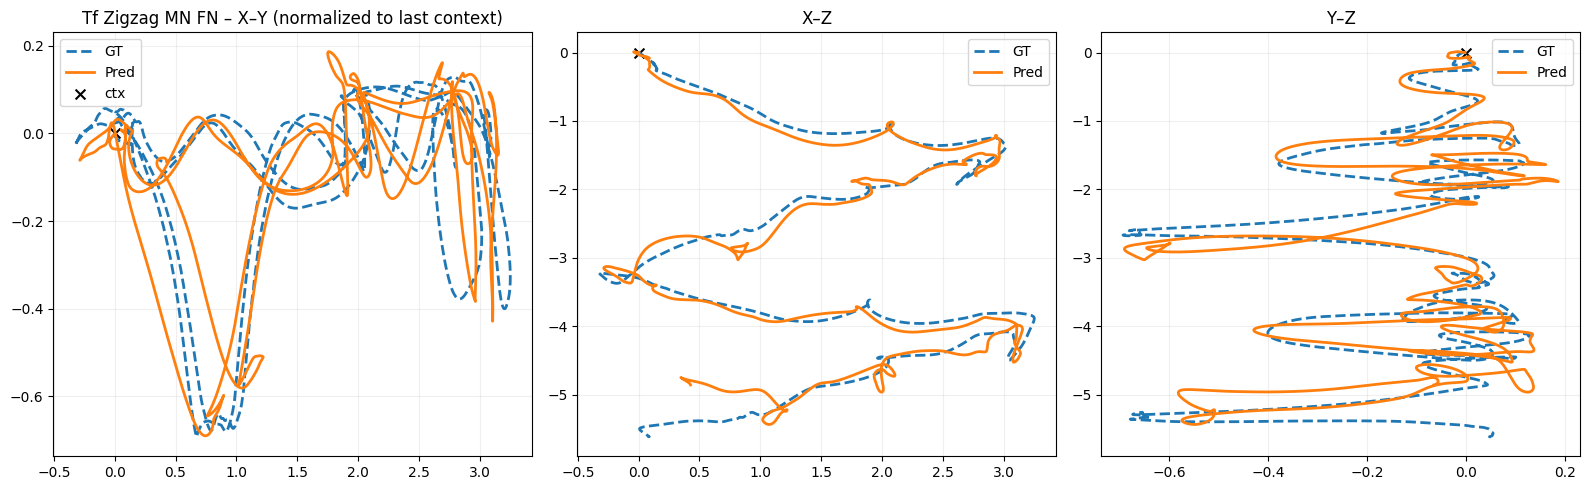

In [52]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D7_All_CSVs/cleaned_Take 091317_Sub8_NewZigZag2 01.10.40 PM edit.npy"
arr = np.load(file_path).astype(np.float32)
#model, mu, sig = model_D, mu_D, sig_D
model, mu, sig = model_N, mu_N, sig_N
pred_full, valid_mask = predict_full_file(arr, model, mu, sig,seq_in=SEQ_IN, seq_out=SEQ_OUT, step=1, device=DEVICE)

plot_3d(gt=arr, pred=pred_full,title="Tf Zigzag MN FN",xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(12,9))

plot_2d(gt=arr, pred=pred_full, title="Tf Zigzag MN FN", xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(16,5))

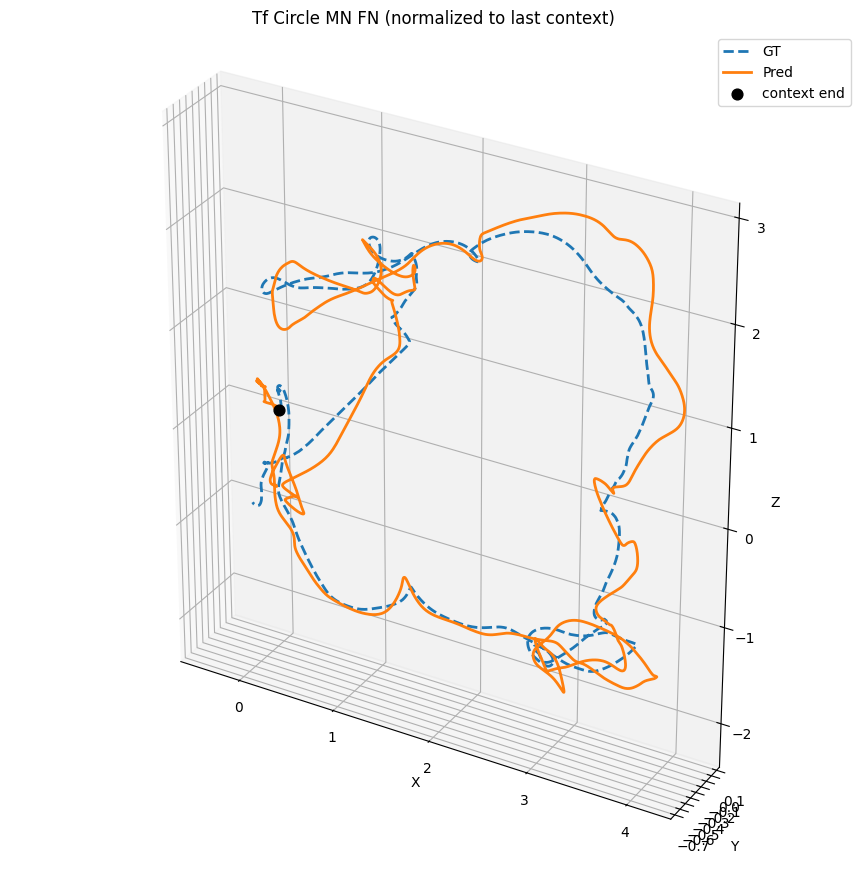

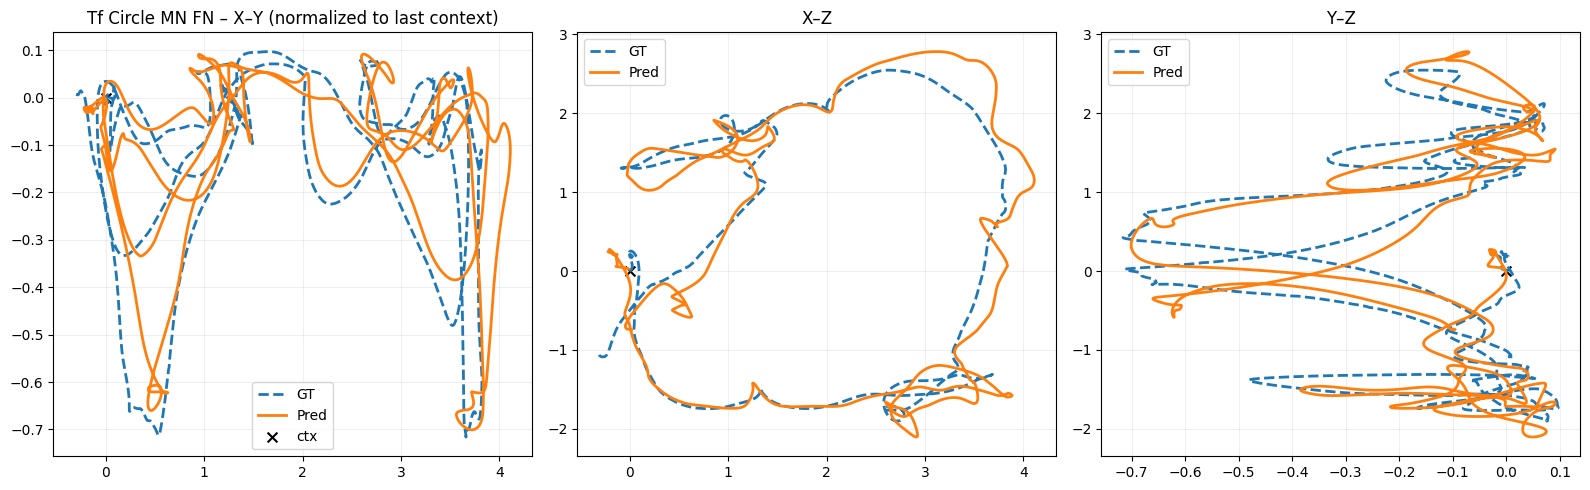

In [53]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D9_All_CSVs/cleaned_Take 091517_Sub10_Circle2 01.11.06 PM edit.npy"
arr = np.load(file_path).astype(np.float32)
#model, mu, sig = model_D, mu_D, sig_D
model, mu, sig = model_N, mu_N, sig_N
pred_full, valid_mask = predict_full_file(arr, model, mu, sig,seq_in=SEQ_IN, seq_out=SEQ_OUT, step=1, device=DEVICE)

plot_3d(gt=arr, pred=pred_full,title="Tf Circle MN FN",xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(12,9))

plot_2d(gt=arr, pred=pred_full, title="Tf Circle MN FN", xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(16,5))

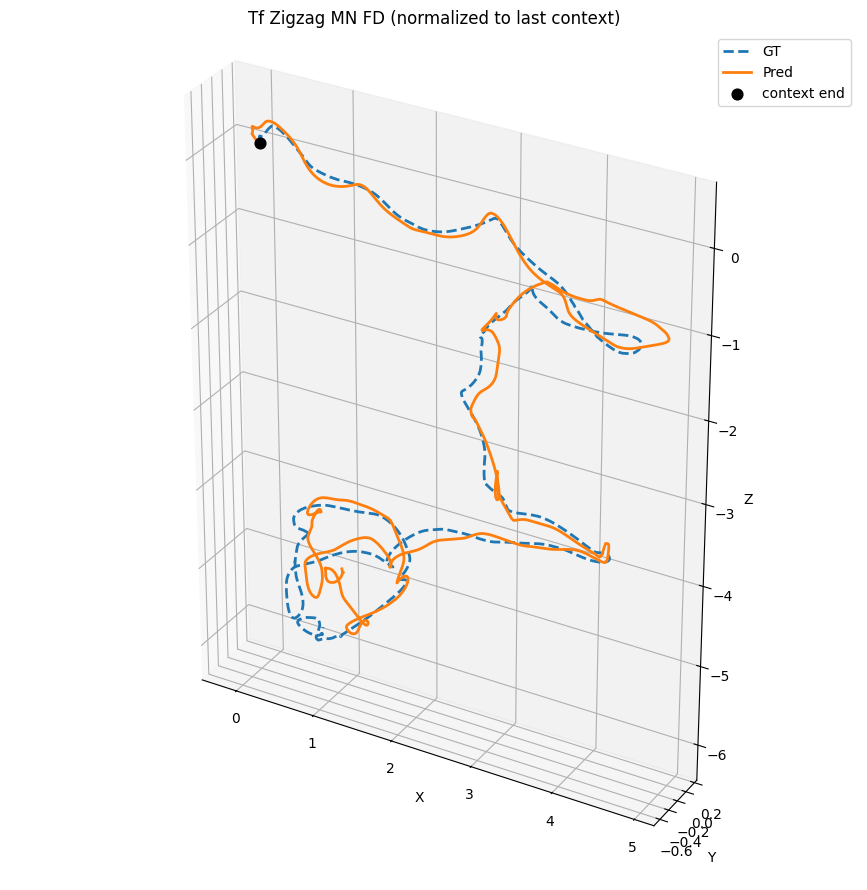

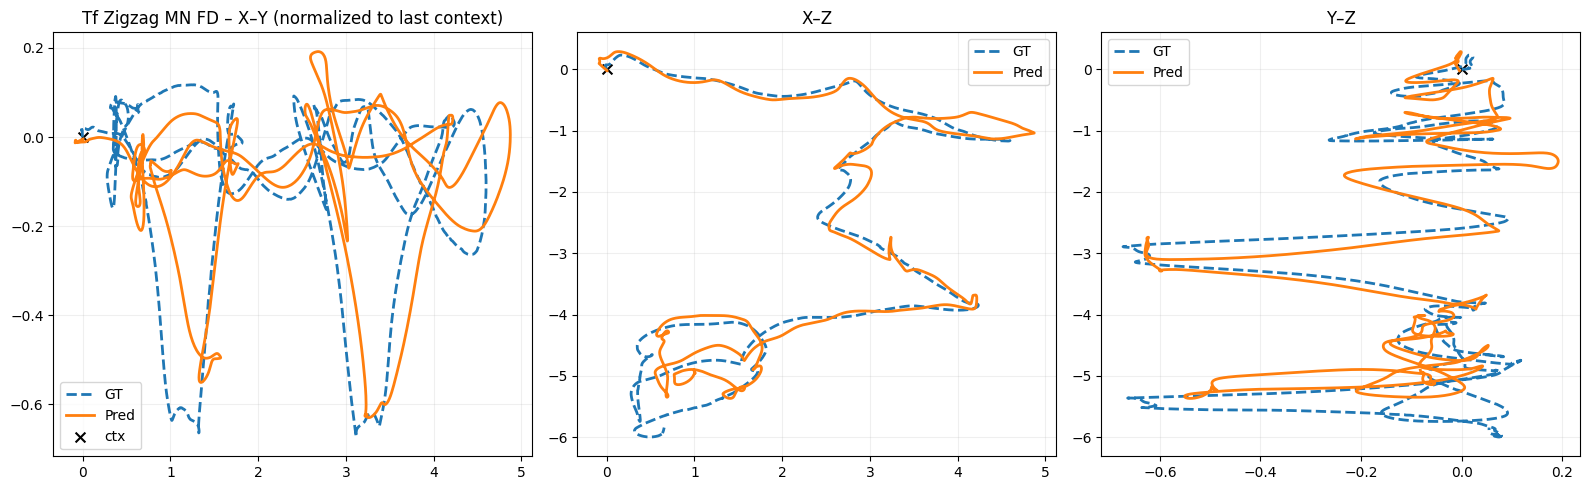

In [54]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D1_All_CSVs/cleaned_Take 072817_Sub1_NewZigZag1 12.26.30 PM edit.npy"
arr = np.load(file_path).astype(np.float32)
#model, mu, sig = model_D, mu_D, sig_D
model, mu, sig = model_N, mu_N, sig_N
pred_full, valid_mask = predict_full_file(arr, model, mu, sig,seq_in=SEQ_IN, seq_out=SEQ_OUT, step=1, device=DEVICE)

plot_3d(gt=arr, pred=pred_full,title="Tf Zigzag MN FD",xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(12,9))

plot_2d(gt=arr, pred=pred_full, title="Tf Zigzag MN FD", xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(16,5))

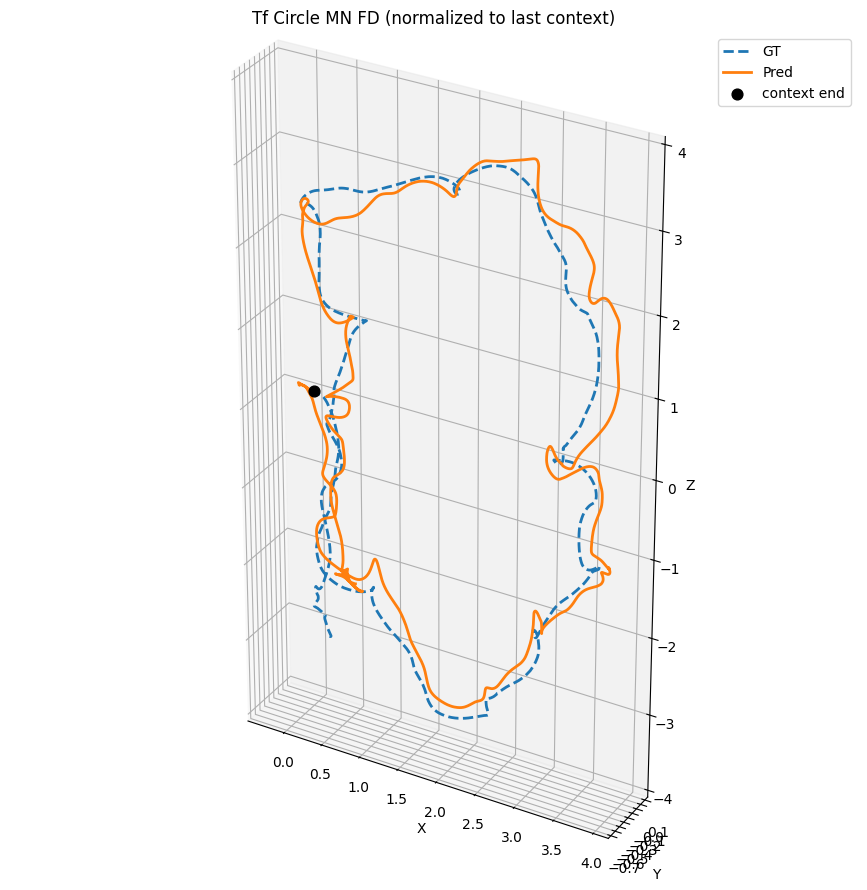

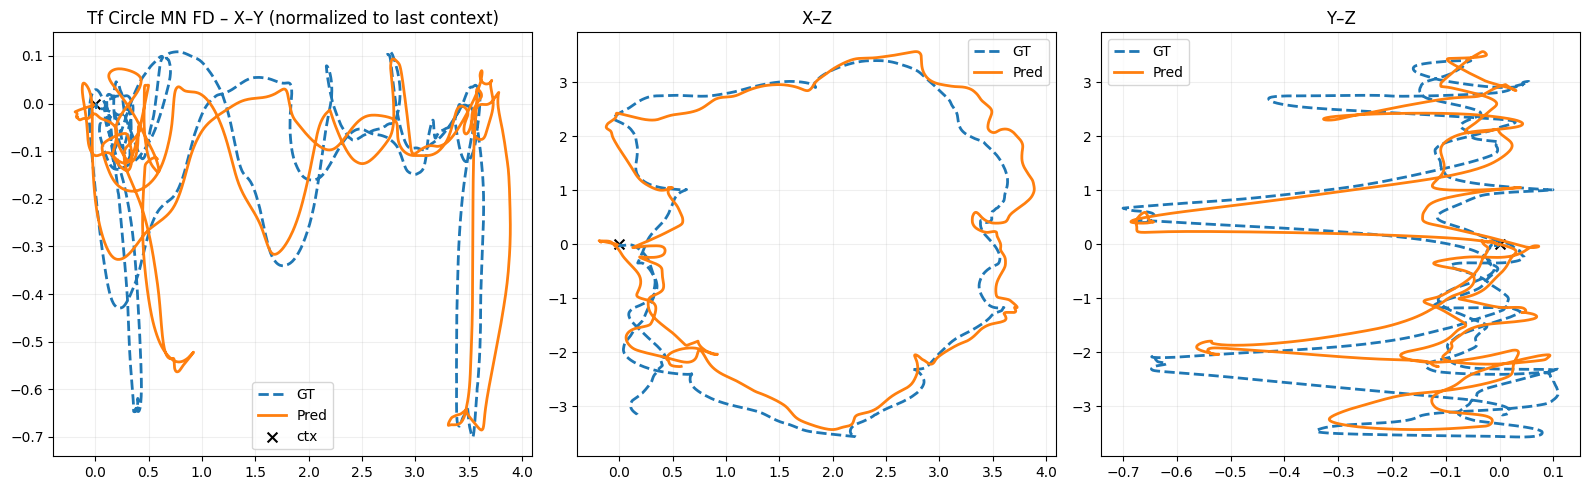

In [55]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D2_All_CSVs/cleaned_Take 080317_Sub2_Circle3 10.41.27 AM edit.npy"
arr = np.load(file_path).astype(np.float32)
#model, mu, sig = model_D, mu_D, sig_D
model, mu, sig = model_N, mu_N, sig_N
pred_full, valid_mask = predict_full_file(arr, model, mu, sig,seq_in=SEQ_IN, seq_out=SEQ_OUT, step=1, device=DEVICE)

plot_3d(gt=arr, pred=pred_full,title="Tf Circle MN FD",xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(12,9))

plot_2d(gt=arr, pred=pred_full, title="Tf Circle MN FD", xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(16,5))

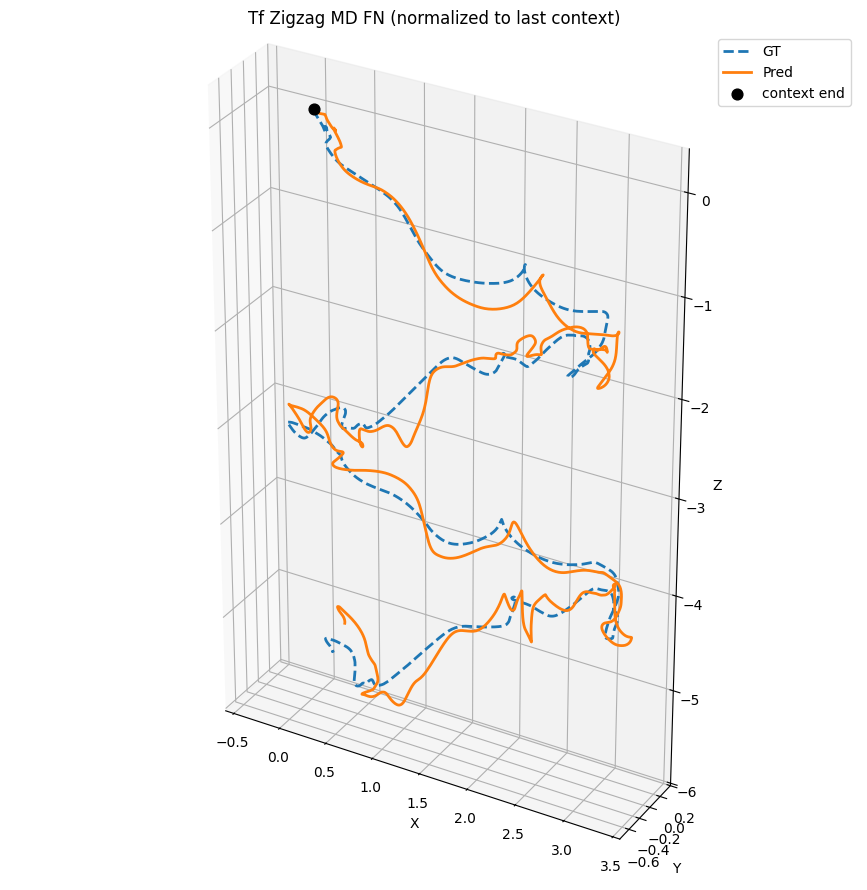

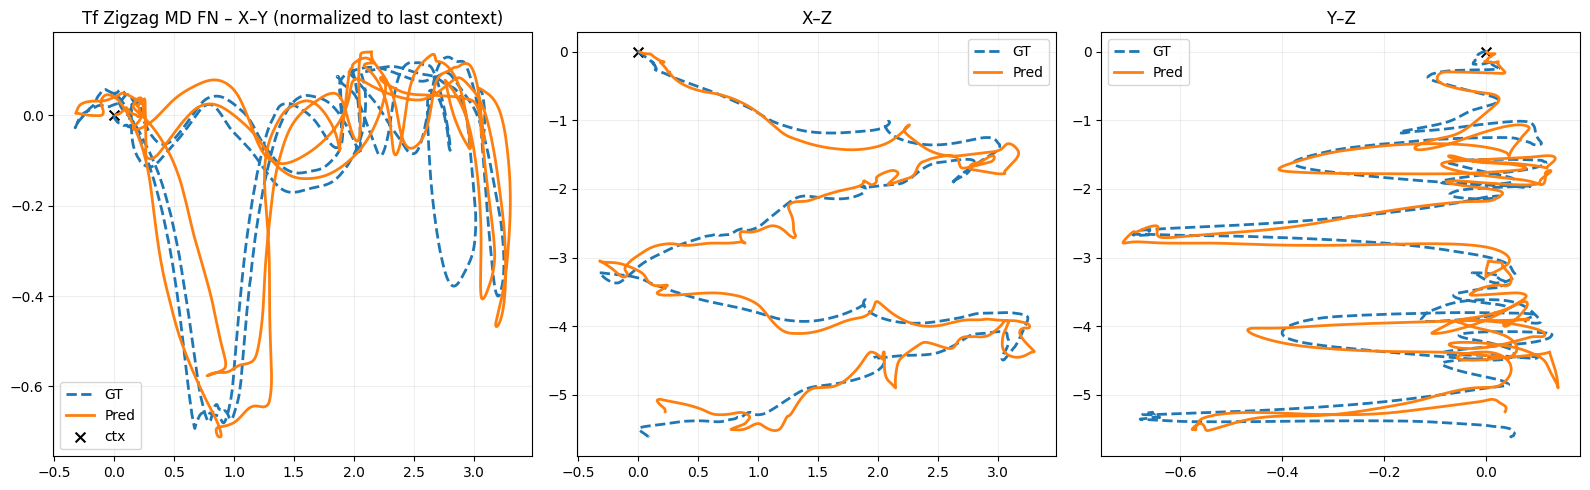

In [56]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D7_All_CSVs/cleaned_Take 091317_Sub8_NewZigZag2 01.10.40 PM edit.npy"
arr = np.load(file_path).astype(np.float32)
model, mu, sig = model_D, mu_D, sig_D
# model, mu, sig = model_N, mu_N, sig_N
pred_full, valid_mask = predict_full_file(arr, model, mu, sig,seq_in=SEQ_IN, seq_out=SEQ_OUT, step=1, device=DEVICE)

plot_3d(gt=arr, pred=pred_full,title="Tf Zigzag MD FN",xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(12,9))

plot_2d(gt=arr, pred=pred_full, title="Tf Zigzag MD FN", xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(16,5))

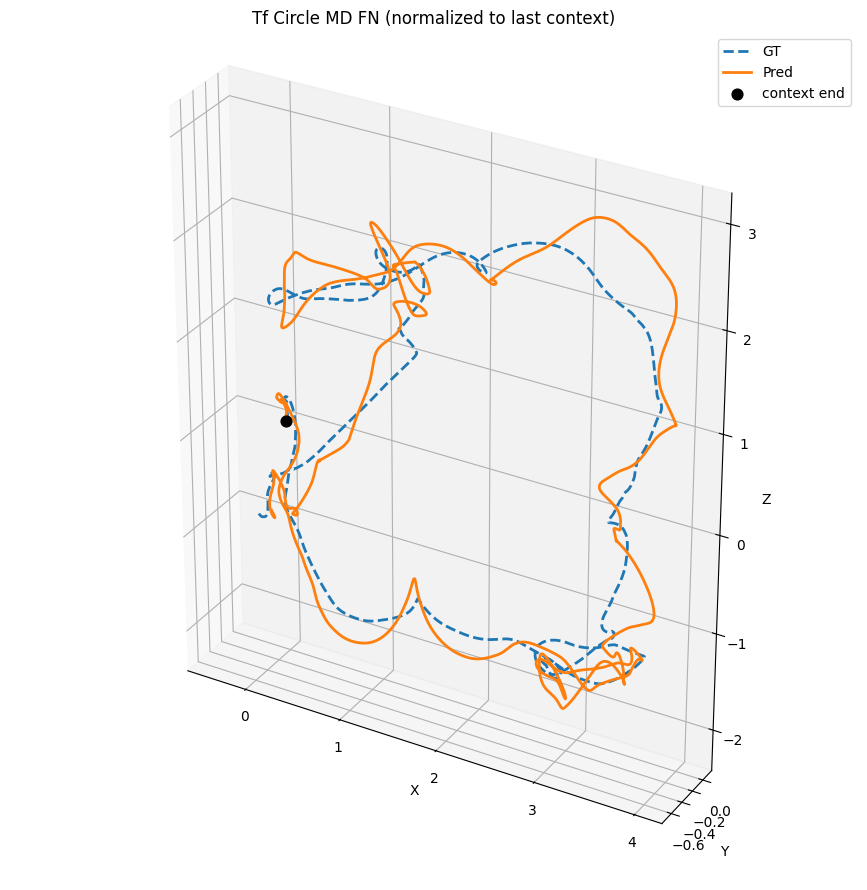

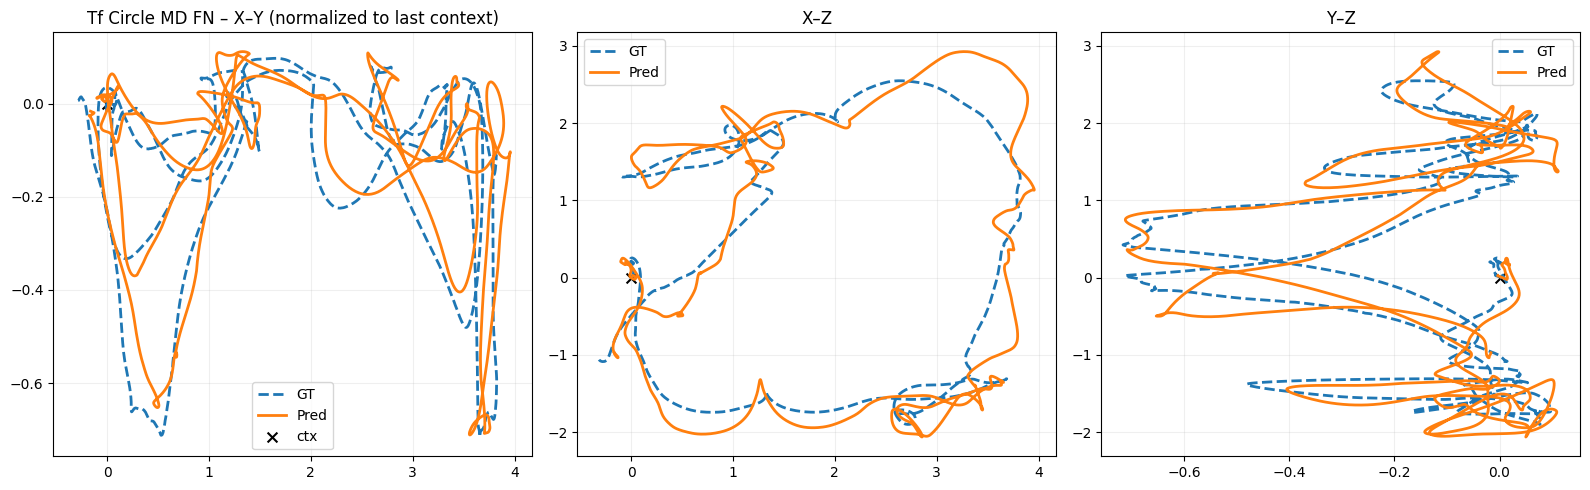

In [47]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D9_All_CSVs/cleaned_Take 091517_Sub10_Circle2 01.11.06 PM edit.npy"
arr = np.load(file_path).astype(np.float32)
model, mu, sig = model_D, mu_D, sig_D
# model, mu, sig = model_N, mu_N, sig_N
pred_full, valid_mask = predict_full_file(arr, model, mu, sig,seq_in=SEQ_IN, seq_out=SEQ_OUT, step=1, device=DEVICE)

plot_3d(gt=arr, pred=pred_full,title="Tf Circle MD FN",xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(12,9))

plot_2d(gt=arr, pred=pred_full, title="Tf Circle MD FN", xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(16,5))

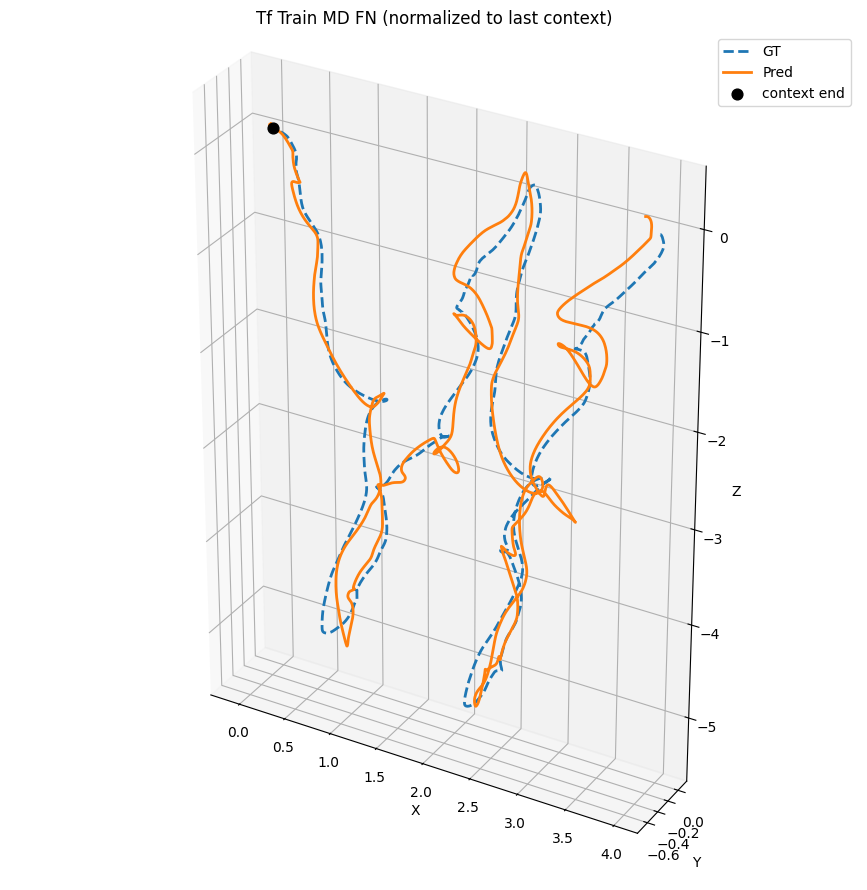

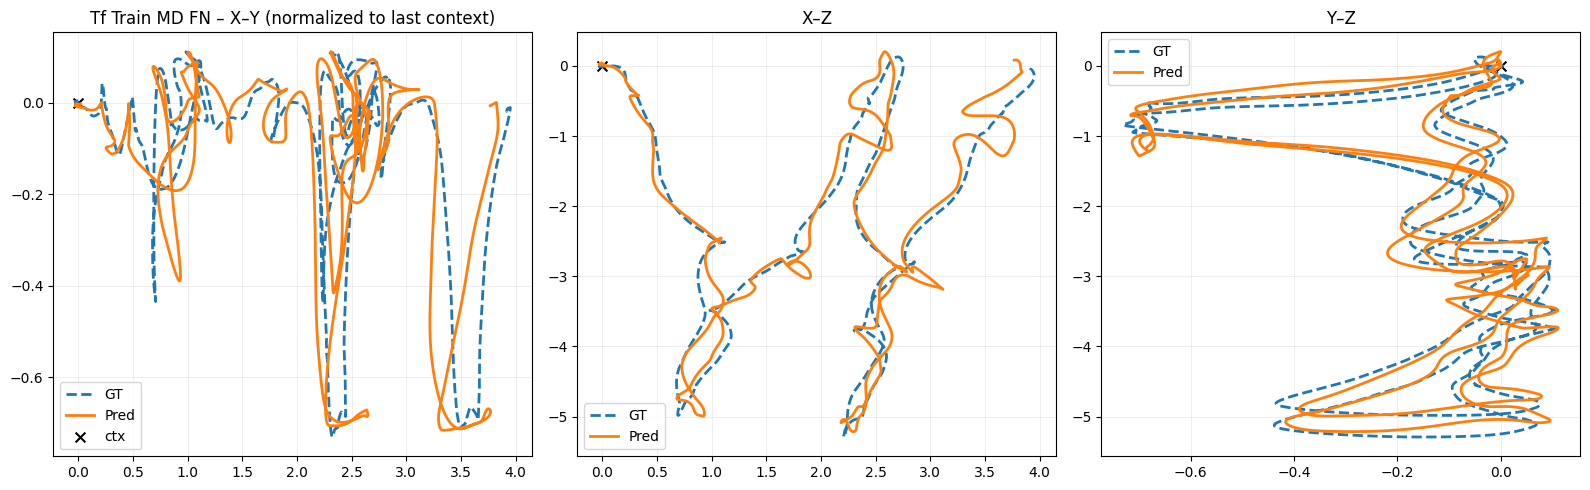

In [48]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D9_All_CSVs/cleaned_Take 091517_Sub10_train3 01.00.35 PM edit.npy"
arr = np.load(file_path).astype(np.float32)
model, mu, sig = model_D, mu_D, sig_D
# model, mu, sig = model_N, mu_N, sig_N
pred_full, valid_mask = predict_full_file(arr, model, mu, sig,seq_in=SEQ_IN, seq_out=SEQ_OUT, step=1, device=DEVICE)

plot_3d(gt=arr, pred=pred_full,title="Tf Train MD FN",xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(12,9))

plot_2d(gt=arr, pred=pred_full, title="Tf Train MD FN", xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(16,5))

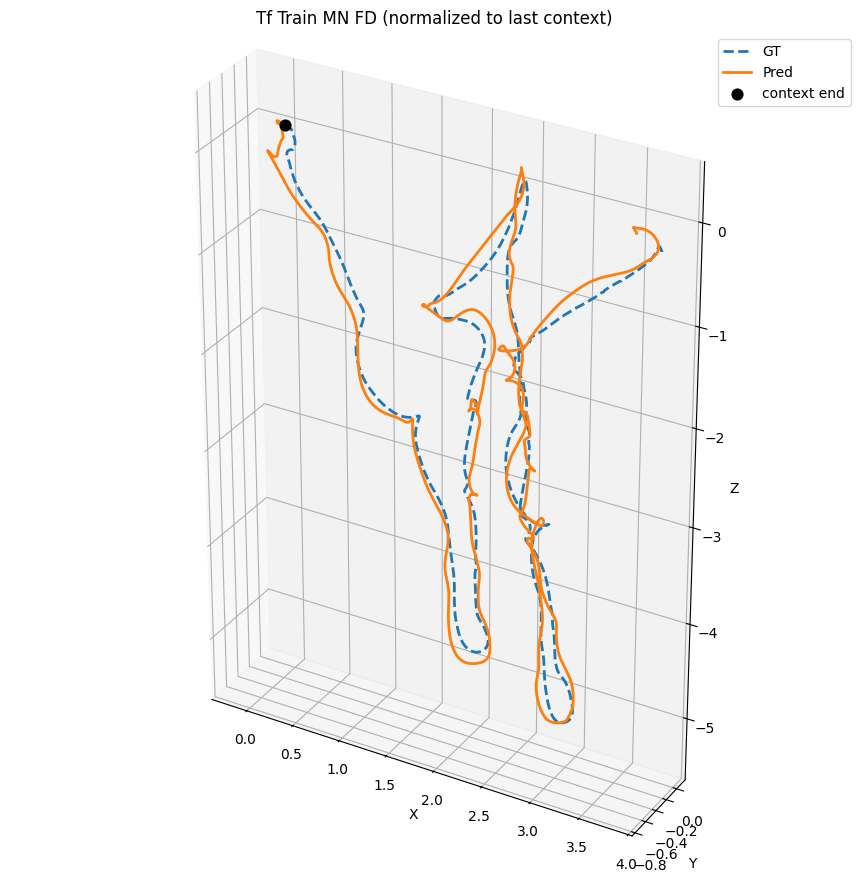

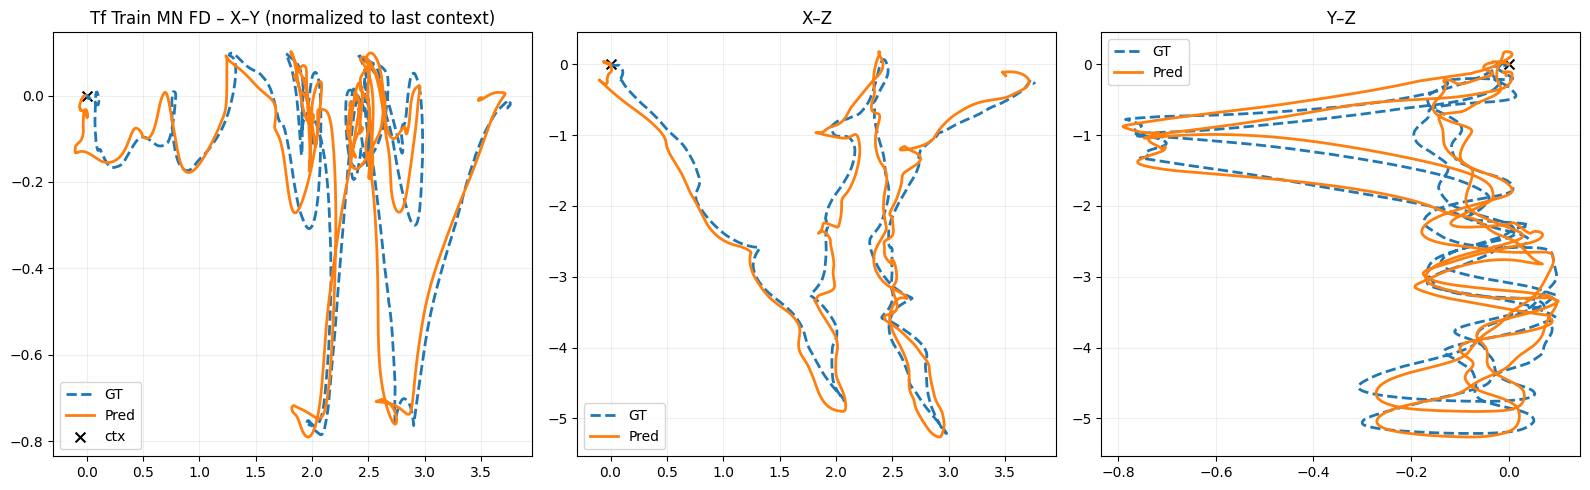

In [49]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D3_All_CSVs/cleaned_Take 090617_Sub4_train1 01.41.03 PM edit.npy"
arr = np.load(file_path).astype(np.float32)
#model, mu, sig = model_D, mu_D, sig_D
model, mu, sig = model_N, mu_N, sig_N
pred_full, valid_mask = predict_full_file(arr, model, mu, sig,seq_in=SEQ_IN, seq_out=SEQ_OUT, step=1, device=DEVICE)

plot_3d(gt=arr, pred=pred_full,title="Tf Train MN FD",xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(12,9))

plot_2d(gt=arr, pred=pred_full, title="Tf Train MN FD", xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30, figsize=(16,5))